# Fundamentos de la Computación Cuántica - Segunda Entrega

A lo largo de la _notebook_, se resolverán los ejercicios solicitados por la cátedra de la materia optativa Fundamentos de la Computación Cuántica. Estos son:

a. Ejercicio 10 del TP de Operaciones (Parte I).

b. Ejemplo 1 del ejercicio 1 del TP de Paralelismo Cuántico (Deutsch-Jozsa, función constante igual a 1).

c. Ejemplo 3 del ejercicio 1 del TP de Paralelismo Cuántico (Deutsch-Jozsa, función balanceada).

d. Ejemplo 4 del ejercicio 1 del TP de Paralelismo Cuántico (Deutsch-Jozsa, función **no** balanceada **ni** constante).

Para ello, se utilizará el _framework_ Qiskit.

## Imports

Previo a la resulución de los ejercicios, se realizan las importaciones de las librerías necesarias:

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

Con las importaciones requeridas realizadas, se prosigue con la resolución de los ejercicios indicados.

## A) Full-Adder con Operandos de 4 Qubits

Corresponde al ejercicio 10 del TP de operaciones (parte I), cuya consigna es la siguiente:

_Basándose en el ejercicio 9, implemente en el simulador un sumador completo entre dos operandos de tamaño 4 qubits. Utilice subcircuitos._

Para ello, debe resolverse primero el ejercicio 9 en Qiskit, cuya consigna es:

_Implemente un sumador completo con operandos de un qubit (enfoque clásico) basándose en computación reversible clásica, mediante el uso de compuertas C-NOT y Toffoli (CC-NOT). Utilice el simulador._

### Full-Adder

A continuación, se realiza el planteo del circuito:

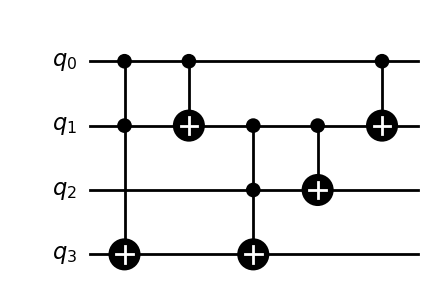

In [4]:
full_adder = QuantumCircuit(4, name="Full-Adder");

full_adder.ccx(0, 1, 3)
full_adder.cx(0, 1)
full_adder.ccx(1, 2, 3)
full_adder.cx(1, 2)
full_adder.cx(0, 1)

full_adder.draw(output='mpl', style='bw')

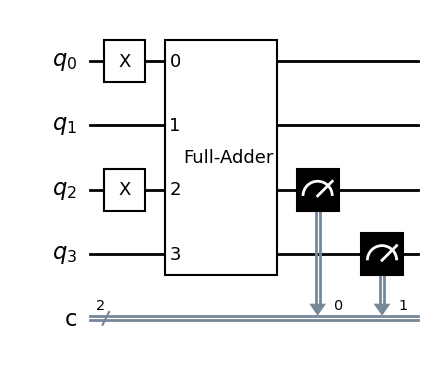

In [5]:
full_adder_measured = QuantumCircuit(4, 2, name="Full-Adder-Measured")

full_adder_measured.x(0)
full_adder_measured.x(2)

full_adder_measured.append(full_adder, [0, 1, 2, 3])

full_adder_measured.measure(2, 0)
full_adder_measured.measure(3, 1)

full_adder_measured.draw(output='mpl', style='bw')

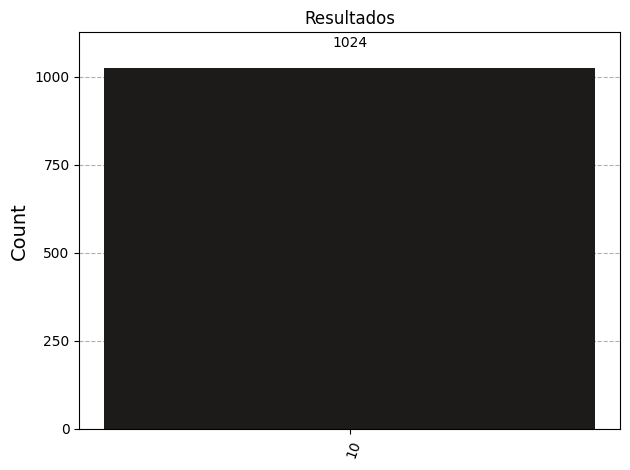

In [6]:
simulator = AerSimulator()

transpiled = transpile(full_adder_measured, simulator)
jobs = simulator.run(transpiled, shots=1024)
result = jobs.result()
counts = result.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

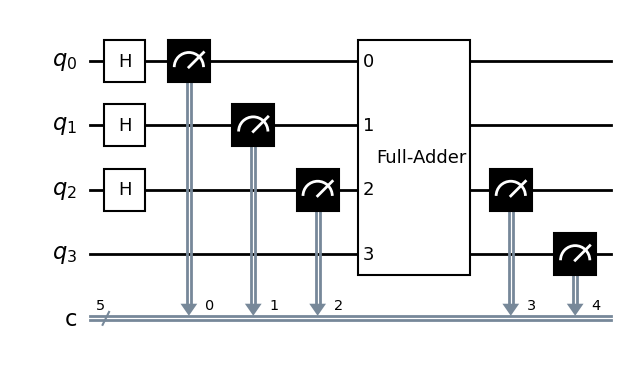

In [7]:
# --- 2. Creación del Circuito de Prueba (8 Combinaciones) ---
# c[0]: Entrada A (q0)
# c[1]: Entrada B (q1)
# c[2]: Entrada Cin (q2)
# c[3]: Salida S (q2)
# c[4]: Salia Cout (q3)
full_adder_measured = QuantumCircuit(4, 5) 

# Entradas en superposición.
full_adder_measured.h([0, 1, 2])

# Medición de las entradas (A, B y Cin) en bit 0, 1 y 2, respectivamente.
full_adder_measured.measure(0, 0)
full_adder_measured.measure(1, 1)
full_adder_measured.measure(2, 2)

# Aplicación de la compuerta Full-Adder.
full_adder_measured.append(full_adder, [0, 1, 2, 3])

# Medición de las salidas (S y Cout) en bits 3 y 4, respectivamente.
full_adder_measured.measure(2, 3)
full_adder_measured.measure(3, 4)

# Comprobación gráfica del circuito
full_adder_measured.draw(output='mpl', style='bw')

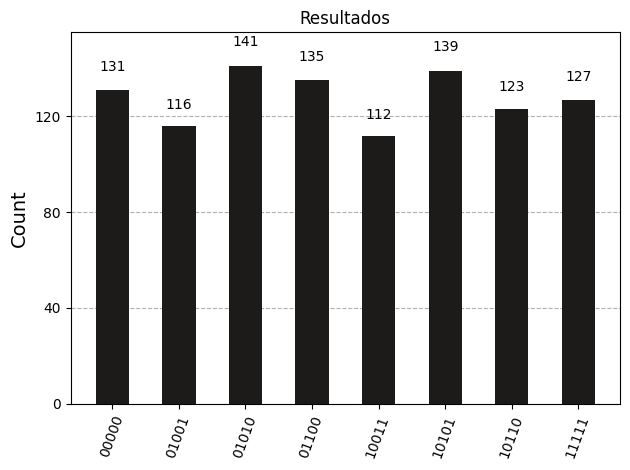

In [8]:
# --- 3. Ejecución y Resultados ---
simulator = AerSimulator()
transpiled = transpile(full_adder_measured, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

Mapeo de columnas

In [9]:
# Definición de anchos de columna para consistencia.
W_BIT = 5  # Ancho para A, B, Cin, S y Cout.
W_COUNT = 15 # Ancho para Frecuencia.
W_CORRECT = 10 # Ancho de la correctitud del resultado.
TOTAL_WIDTH = W_BIT * 5 + W_COUNT + W_CORRECT + 22 # 8 barras y 14 espacios adicionales.

# Separador
def print_separator(width):
    print(f"|{'-' * (width - 2)}|") # -2 por las barras.

# Título
print_separator(TOTAL_WIDTH)
print(f"|{'Tabla de Verdad Experimental del Full-Adder':^{TOTAL_WIDTH - 2}}|") # -2 por las barras.
print_separator(TOTAL_WIDTH)
# Encabezados
print(f"| {'A':^{W_BIT}} | {'B':^{W_BIT}} | {'Cin':^{W_BIT}} | {'S':^{W_BIT}} | {'Cout':^{W_BIT}} | {'Frecuencia':^{W_COUNT}} | {'¿Correcto?':^{W_CORRECT}} |")
print_separator(TOTAL_WIDTH)

for bitstring, count in counts.items():

    # Correspondencia de la salida.
    # El bit menos significativo aparece
    # último en el bitstring.
    a = int(bitstring[4])
    b = int(bitstring[3])
    cin = int(bitstring[2])
    s = int(bitstring[1])
    cout = int(bitstring[0])
    
    # En Python,
    # & -> And (. o ^).
    # | -> Or (v).
    # ^ -> Xor.
    
    # Los resultados correcto son S = A^B^Cin y Cout = (A^B)Cin v (A.B).
    # Se calcula el resultado esperado para un FA funcional.
    expected_sum = a ^ b ^ cin
    expected_cout = (a & b) | (cin & (a ^ b))

    # Comprobación de la lógica del FA:
    is_correct = "NO"
    if s == expected_sum and cout == expected_cout:
        is_correct = "SÍ"

    print(f"| {a:^{W_BIT}} | {b:^{W_BIT}} | {cin:^{W_BIT}} | {s:^{W_BIT}} | {cout:^{W_BIT}} | {count:^{W_COUNT}} | {is_correct:^{W_CORRECT}} |")

print_separator(TOTAL_WIDTH)

|----------------------------------------------------------------------|
|             Tabla de Verdad Experimental del Full-Adder              |
|----------------------------------------------------------------------|
|   A   |   B   |  Cin  |   S   | Cout  |   Frecuencia    | ¿Correcto? |
|----------------------------------------------------------------------|
|   0   |   1   |   1   |   0   |   1   |       123       |     SÍ     |
|   0   |   1   |   0   |   1   |   0   |       141       |     SÍ     |
|   1   |   1   |   1   |   1   |   1   |       127       |     SÍ     |
|   1   |   1   |   0   |   0   |   1   |       112       |     SÍ     |
|   1   |   0   |   1   |   0   |   1   |       139       |     SÍ     |
|   0   |   0   |   0   |   0   |   0   |       131       |     SÍ     |
|   1   |   0   |   0   |   1   |   0   |       116       |     SÍ     |
|   0   |   0   |   1   |   1   |   0   |       135       |     SÍ     |
|--------------------------------------------------

Habiendo comprobado que el Full-Adder funciona correctamente, se plantea el Full-Adder de cuatro operandos.

### Full-Adder-4

La forma que planteo a continuación difiere de la forma planteada

A0 A1 A2 A3   (4 qubits)
B0 B1 B2 B3   (4 qubits)
Cin inicial    (1 qubit)
Sum qubits     (4 qubits)
Cout final     (1 qubit)


En el informe anterior, la forma que había planteado para resolver este problema era el uso de varios swaps. Esto fue con el objetivo de reducir el número de qubits utilizados (lo cual se consiguió, logrando resolver el problema con 13 qubits). Sin embargo, entiendo ahora mejor que el número de qubits utilizados no es un inconveniente y que lo que debería priorizarse el tiempo de ejecución.

Como consecuencia, el planteo de este circuito difiere del planteado en el informe anterior.

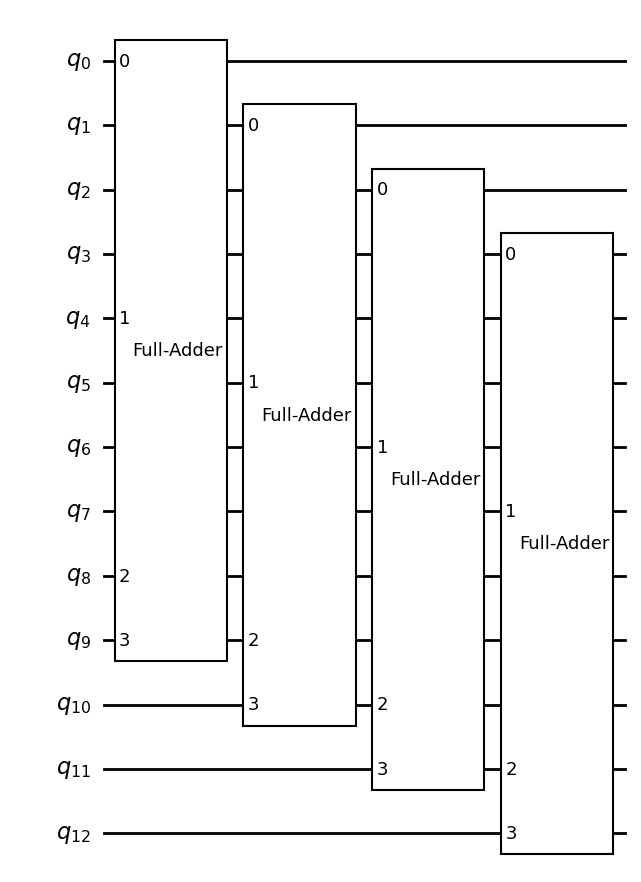

In [10]:
# Sumador de 4 bits usando 4 full adders.
# 13 qubits de entrada.
full_adder_4 = QuantumCircuit(13, name="Full-Adder-4")

# Índices de los qubits
A = [0, 1, 2, 3]
B = [4, 5, 6, 7]
S = [8, 9, 10, 11] # Salidas.
cin = S[0]
cout = [9, 10, 11, 12]
final_cout = cout[3] # Último cout.

# Full adder 0 (LSQ - Least Significant Qubit)
full_adder_4.append(full_adder, [A[0], B[0], S[0], cout[0]])

# Full adder 1
full_adder_4.append(full_adder, [A[1], B[1], S[1], cout[1]])

# Full adder 2
full_adder_4.append(full_adder, [A[2], B[2], S[2], cout[2]])

# Full adder 3 (MSB)
full_adder_4.append(full_adder, [A[3], B[3], S[3], cout[3]])

full_adder_4.draw(output='mpl', style='bw')

Se añaden las mediciones que permitirán realizar la simulación:

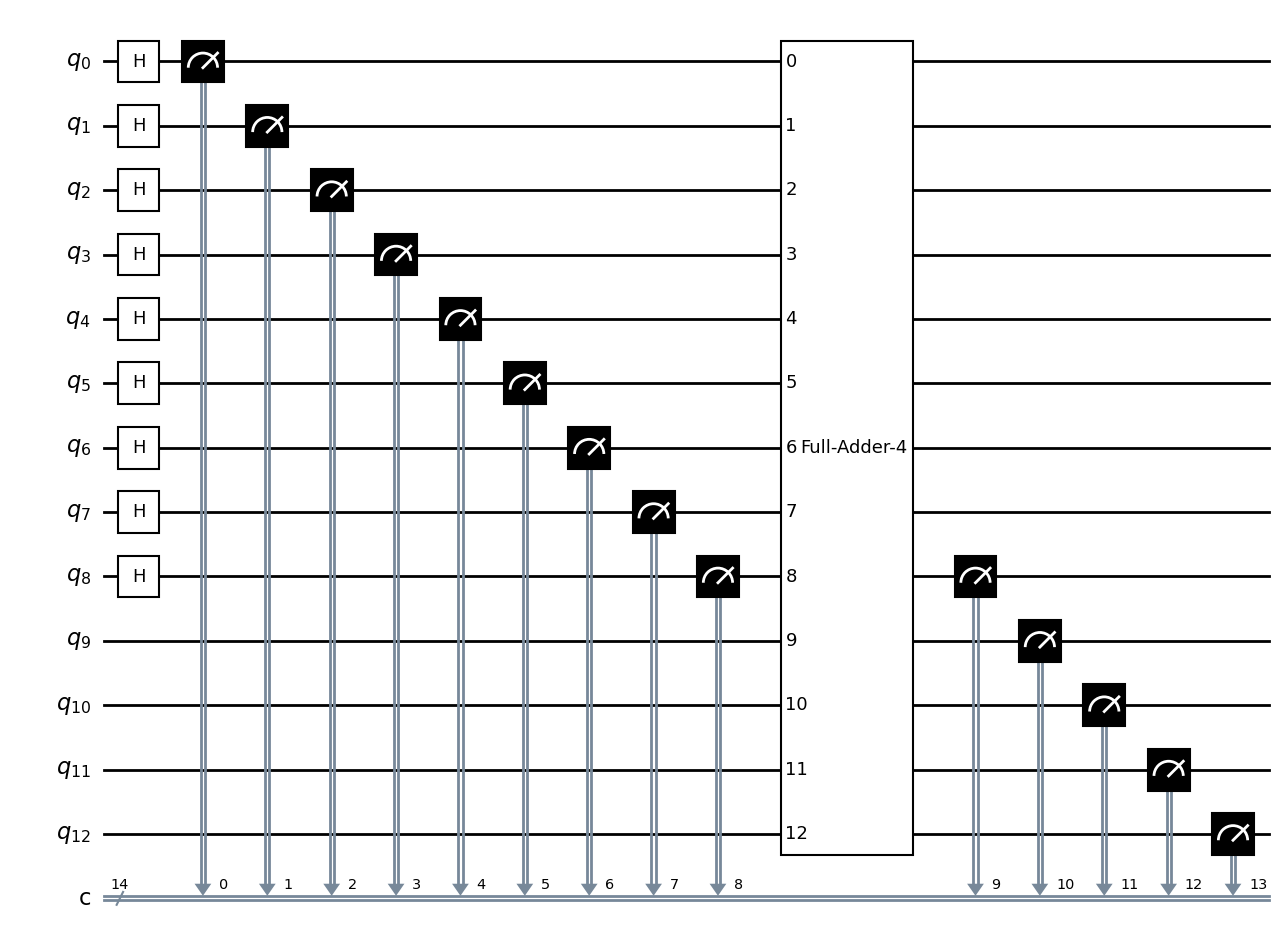

In [11]:
full_adder_4_measured = QuantumCircuit(13, 14)

# Entradas en superposición.
full_adder_4_measured.h([0, 1, 2, 3, 4, 5, 6, 7, 8])

next_measurement_qubit = 0

# Medición de las entradas (A, B y Cin) en bit 0, 1 y 2, respectivamente.
for qubit_number in range(9):
    full_adder_4_measured.measure(qubit_number, next_measurement_qubit)
    next_measurement_qubit += 1

# Aplicación de la compuerta Full-Adder.
full_adder_4_measured.append(full_adder_4, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

for qubit_number in S:
    full_adder_4_measured.measure(qubit_number, next_measurement_qubit)
    next_measurement_qubit += 1

full_adder_4_measured.measure(final_cout, next_measurement_qubit)

# Comprobación gráfica del circuito
full_adder_4_measured.draw(output='mpl', style='bw')

Se realiza la simulación:

In [ ]:
simulator = AerSimulator()
transpiled = transpile(full_adder_4_measured, simulator)
job = simulator.run(transpiled, shots=10240)
results = job.result()
counts = results.get_counts(transpiled)

{'10100111110100': 22, '01001101000100': 15, '00111000000111': 16, '11010011001110': 16, '10001001011100': 19, '00011100100000': 24, '11001011101011': 17, '10010100101111': 21, '10110011101000': 17, '11000111111000': 22, '10000101011010': 23, '10001101111001': 18, '10011001101101': 20, '10010100111110': 24, '10000010001000': 21, '01011010100001': 17, '10111111001010': 11, '11000110001111': 15, '10001001111010': 23, '01011001010110': 22, '10011110001010': 17, '10100110111000': 13, '01111011010010': 14, '00011000010010': 25, '01100010010011': 13, '01100101100101': 16, '00111001010010': 13, '01011110100000': 18, '01000101000011': 25, '01100100011010': 14, '10001001001101': 16, '01101001011000': 17, '01000100110100': 20, '10110111011000': 21, '10101010101011': 11, '10010101001101': 20, '01100100001011': 14, '10011111100100': 15, '00100000100010': 26, '10010110001001': 25, '01111000011110': 9, '10010001111011': 24, '10101101101110': 15, '01110110010100': 24, '10001001101011': 14, '100101101

Similar al caso del FA, no se consideró apropiado mostrar los resultados del FA4 en un histograma, debido a la gran cantidad de posibles resultados, además de que la lectura de las barras podría ser dificultuosa. Por consiguiente, se definió una función que realice la impresión de cada posible combinación en forma de tabla de verdad, calculando el resultado esperado y corroborando si coincide con el obtenido:

In [ ]:
# Número de bits de los operandos.
N_QUBITS = 4

"""
Si se quiere probar una configuraciń específica, puede hacerse colocaándolas
de la siguiente forma:

counts = {
    '00000000000000': 0,
    '00001100000000': 1024, 
    ...,
}
"""

# Anchos de columnas.
W_QUBITS = max(11, N_QUBITS * 3 - 1)  # Para A, B y S.
W_COUNT = 12
W_CHECK = 16

# Ancho total: 5 columnas de bits + count + check + separadores.
TOTAL_WIDTH = 5 * W_QUBITS + W_COUNT + W_CHECK + 14 + 8

def parse(substring, n):
    """
    Extracción de los qubits del bitstring, siguiendo, de acuerdo a cómo se plantearon
    las mediciones, el siguiente formato: [Cout][SN..S0][Cin][BN..B0][AN..A0]
    
    Debido a que los bits en el string están como [Xn-1...X0], hay que invertirlos para obtener [X0...Xn-1].
    """
    i = 0
    parsed_cout = int(substring[i]); i += 1
    parsed_s = [int(substring[i+n-1-j]) for j in range(n)]; i += n  # Invertido: se guarda S0 primero.
    parsed_cin = int(substring[i]); i += 1
    parsed_b = [int(substring[i+n-1-j]) for j in range(n)]; i += n  # Invertido: se guarda B0 primero.
    parsed_a = [int(substring[i+n-1-j]) for j in range(n)]          # Invertido: se guarda A0 primero.
    return parsed_a, parsed_b, parsed_cin, parsed_s, parsed_cout

# Calcular suma esperada
def expected(A, B, cin, n):
    """
    Usando operadores de corrimiento de bits, se calcula la suma esperada.
    """
    a = sum(A[i] << i for i in range(n))
    b = sum(B[i] << i for i in range(n))
    total = a + b + cin
    expected_s = [(total >> i) & 1 for i in range(n)]
    expected_cout = (total >> n) & 1
    return expected_s, expected_cout

# Título de la tabla.
print_separator(TOTAL_WIDTH)
print(f"|{'Tabla de Verdad - Sumador de ' + str(N_QUBITS) + ' bits':^{TOTAL_WIDTH - 2}}|")
print_separator(TOTAL_WIDTH)

# Encabezados.
headers = [f"A{N_QUBITS-1}...A0", f"B{N_QUBITS-1}...B0", "Cin", f"S{N_QUBITS-1}...S0", "Cout"]
print(f"| {headers[0]:^{W_QUBITS}} | {headers[1]:^{W_QUBITS}} | {headers[2]:^{W_QUBITS}} | {headers[3]:^{W_QUBITS}} | {headers[4]:^{W_QUBITS}} | {'Frecuencia':^{W_COUNT}} | {'¿Correcto?':^{W_CHECK}} |")
print_separator(TOTAL_WIDTH)

# Generación de cada fila.
for bitstring, count in sorted(counts.items()):
    parsed_a, parsed_b, parsed_cin, parsed_s, parsed_cout = parse(bitstring, N_QUBITS)
    expected_s, expected_cout = expected(parsed_a, parsed_b, parsed_cin, N_QUBITS)
    
    ok = "SÍ" if parsed_s == expected_s and parsed_cout == expected_cout else "NO"
    
    # Se muestran los bits de mayor a menor índice.
    a_str = ' '.join(str(parsed_a[i]) for i in range(N_QUBITS-1, -1, -1))
    b_str = ' '.join(str(parsed_b[i]) for i in range(N_QUBITS-1, -1, -1))
    s_str = ' '.join(str(parsed_s[i]) for i in range(N_QUBITS-1, -1, -1))
    
    print(f"| {a_str:^{W_QUBITS}} | {b_str:^{W_QUBITS}} | {parsed_cin:^{W_QUBITS}} | {s_str:^{W_QUBITS}} | {parsed_cout:^{W_QUBITS}} | {count:^{W_COUNT}} | {ok:^{W_CHECK}} |")

print_separator(TOTAL_WIDTH)

# Impresión de las estadísticas.
total = sum(counts.values())
correct = sum(count for s, count in counts.items() 
            if parse(s, N_QUBITS)[3:] == expected(*parse(s, N_QUBITS)[:3], N_QUBITS))

print(f"\nTotal mediciones: {total}")
print(f"Configuraciones únicas: {len(counts)}")
print(f"Precisión: {100 * correct / total:.2f}%" if total > 0 else "N/A")

|-------------------------------------------------------------------------------------------------------|
|                                  Tabla de Verdad - Sumador de 4 bits                                  |
|-------------------------------------------------------------------------------------------------------|
|   A3...A0   |   B3...B0   |     Cin     |   S3...S0   |    Cout     |  Frecuencia  |    ¿Correcto?    |
|-------------------------------------------------------------------------------------------------------|
|   0 0 0 0   |   0 0 0 0   |      0      |   0 0 0 0   |      0      |      22      |        SÍ        |
|   0 0 0 1   |   0 0 0 0   |      0      |   0 0 0 1   |      0      |      24      |        SÍ        |
|   0 0 0 0   |   0 0 0 1   |      0      |   0 0 0 1   |      0      |      23      |        SÍ        |
|   0 0 0 0   |   0 0 0 0   |      1      |   0 0 0 1   |      0      |      16      |        SÍ        |
|   0 0 1 0   |   0 0 0 0   |      0      |   

Como puede observarse, la precisión del circuito es del 100 %, lo que indica que el FA4 fue implementado correctamente.

## B) Deutsch-Jozsa - Función Constante Igual a 1

Corresponde al ejemplo 1 del ejercicio 1 del TP de paralelismo.

![ejemploNro1.png](images/ejemploNro1.png)

Como primer paso, se construye el circuito de Deutsch-Jozsa para funciones de _N_ entradas y un resultado. Este se plantea de forma que sea reutilizable, ya que los demás incisos también la requiren.

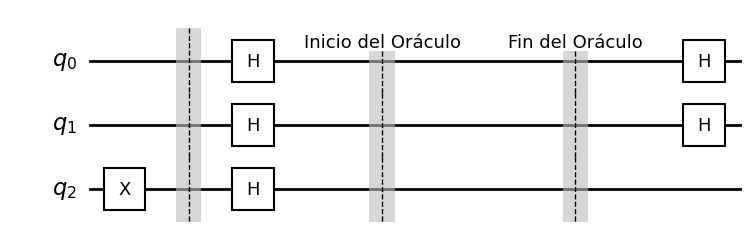

In [14]:
def deutsch_jozsa(n_qubits, oracle_function=None):
    """
    Crea un circuito Deutsch-Jozsa de n qubits.
    
    Args:
        n_qubits: Número de qubits de entrada (+ 1 qubit auxiliar).
        oracle_function: Función que recibe el circuito y aplica el oráculo
    """
    
    deutsch_jozsa = QuantumCircuit(n_qubits, name="Deutsch-Jozsa")
    
    # Aplicación de la compuerta X al último qubit, puesto a que,
    # por defecto, en Quiskit todos los qubits comienzan en 0 y, el
    # algoritmo, establece que el qubit auxiliar debe comenzar en 1.
    deutsch_jozsa.x(n_qubits - 1)
    
    # Separación mediante barrera para que quede más estético y ordenado.
    deutsch_jozsa.barrier()
    
    # Aplicación de Hadamards a las entradas y al qubit auxiliar.
    deutsch_jozsa.h(range(n_qubits))
    deutsch_jozsa.barrier(label="Inicio del Oráculo")
    
    # De existir, se aplica el oráculo.
    if oracle_function:
        oracle_function(deutsch_jozsa, n_qubits)
    
    deutsch_jozsa.barrier(label="Fin del Oráculo")
    
    # Aplicación de Hadamards a los qubits de entradas.
    deutsch_jozsa.h(range(n_qubits - 1))
    
    return deutsch_jozsa

circuit = deutsch_jozsa(3)
circuit.draw(output='mpl', style='bw')

A continuación se construye la función (oráculo en el contexto del algoritmo) del enunciado, la cual es `f(x_2, x_1, x_0) = 1`.

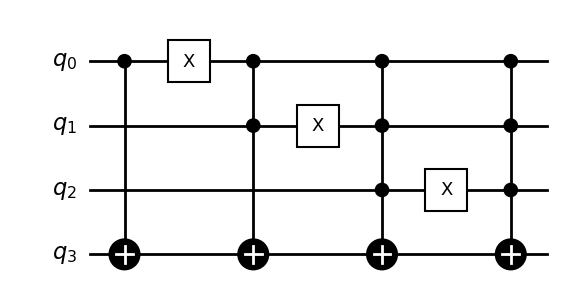

In [15]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.cx(0, accesible_qubits)
    quantum_circuit.x(0)
    quantum_circuit.ccx(0, 1, accesible_qubits)
    quantum_circuit.x(1)
    # Todos los qubits excepto el último como controles
    quantum_circuit.mcx(list(range(accesible_qubits)), accesible_qubits)
    quantum_circuit.x(2)
    quantum_circuit.mcx(list(range(accesible_qubits)), accesible_qubits)
    
    return quantum_circuit
    

qc = QuantumCircuit(4)
oraculo(qc, 4).draw(output='mpl', style='bw')

El cual puede generalizarse a la siguiente forma:

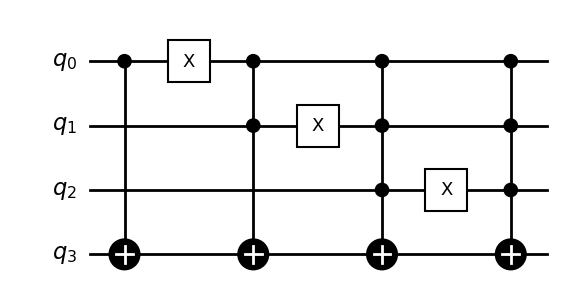

In [16]:
def oraculo(quantum_circuit, number_of_qubits):
    
    if (number_of_qubits < 2):
        return
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    for qubit in range(accesible_qubits):
        quantum_circuit.mcx(list(range(qubit + 1)), accesible_qubits)
        quantum_circuit.x(qubit)
        
    quantum_circuit.mcx(list(range(accesible_qubits)), accesible_qubits)
    
    return quantum_circuit

number_of_qubits = 4
qc = QuantumCircuit(number_of_qubits)

oraculo(qc, number_of_qubits).draw(output='mpl', style='bw')

Aplicando el algoritmo de Deutsch-Jozsa, se obtiene el siguiente resultado:

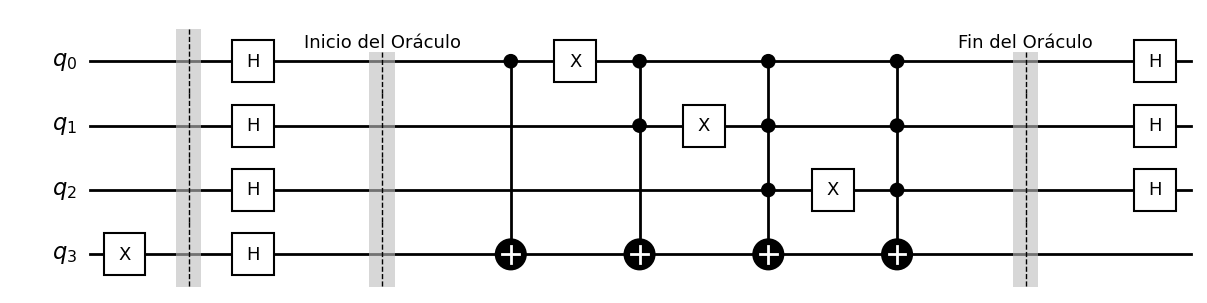

In [17]:
number_of_qubits = 4

result = deutsch_jozsa(number_of_qubits, oraculo)
result.draw(output='mpl', style='bw')

Se añaden las mediciones:

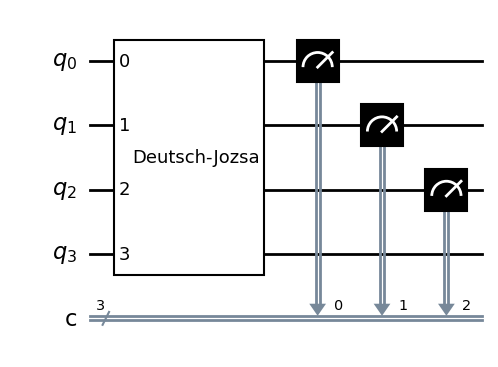

In [18]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits, number_of_qubits - 1)

measured_quantum_circuit.append(result, list(range(number_of_qubits)))

for i in range(number_of_qubits - 1): # -1 ya que no se quiere medir el auxiliar.
    measured_quantum_circuit.measure(i, i)
    
measured_quantum_circuit.draw(output='mpl', style='bw')

Para que f sea constante, debe medir todos ceros. Se realiza la simulación:

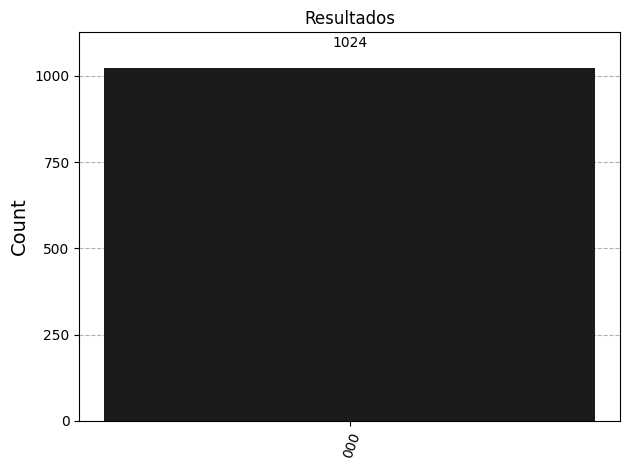

In [ ]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

En Deutsch-Jozsa, no se debe medir el qubit auxiliar, ya que no aporta información sobre si la función es constante o balanceada. Solo nos importan los qubits de entrada.

Durante el oráculo, si la función es constante (como f(x)=1), este qubit puede sufrir un cambio de fase (convertirse en −∣−⟩), pero sigue estando en una superposición.

Cuando mides una superposición perfecta de ∣−⟩ en la base estándar (Z), la física cuántica dicta que tienes un 50% de probabilidad de ver un 0 y un 50% de probabilidad de ver un 1. Eso es exactamente lo que ves en tus resultados (~500 veces 0 y ~500 veces 1).

## Deutsch-Jozsa - Función Balanceada

Corresponde al ejemplo 3 del ejercicio 1 del TP de paralelismo.

![ejemploNro3.png](images/ejemploNro3.png)

Debido a que previamente ya se planteó el algoritmo de Deutsch-Jozsa, ahora solo hace falta plantear el oráculo para la función del ejercicio: f(x2, x1, x0) = 0

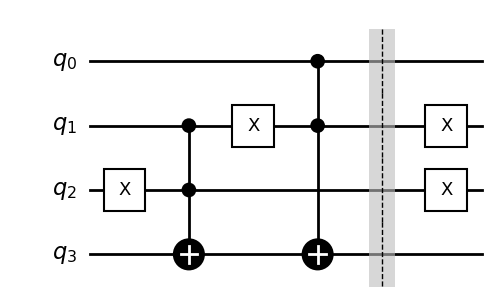

In [20]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.x(2)
    quantum_circuit.ccx(2, 1, accesible_qubits)
    quantum_circuit.x(1)
    quantum_circuit.ccx(1, 0, accesible_qubits)
    
    # Se coloca una barrera para que Qiskit no reordene automáticamente
    # el circuito y, de esta forma, quede como en la teoría.
    quantum_circuit.barrier()
    
    quantum_circuit.x(2)
    quantum_circuit.x(1)
    
    return quantum_circuit
    

qc = QuantumCircuit(4)
oraculo(qc, 4).draw(output='mpl', style='bw')

El cual puede generalizarse para n qubits a:

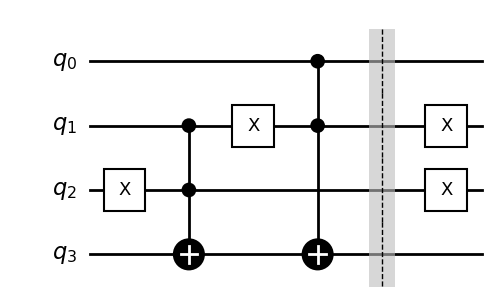

In [21]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que pueden acceder a través
    # los índices. Variable definida para no restar
    # constantemente uno.
    accesible_qubits = number_of_qubits - 1
    
    for qubit in range(accesible_qubits - 1, 0, -1):
        quantum_circuit.x(qubit)
        quantum_circuit.ccx(qubit, qubit - 1, accesible_qubits)
    
    # Barrera para evitar el reordenamiento automático.
    quantum_circuit.barrier()
    
    for qubit in range(accesible_qubits - 1, 0, -1):
        quantum_circuit.x(qubit)
    
    return quantum_circuit
    

number_of_qubits = 4
qc = QuantumCircuit(number_of_qubits)
oraculo(qc, number_of_qubits).draw(output='mpl', style='bw')

Aplicando el algoritmo de Deutsch-Jozsa, se obtiene el siguiente resultado:

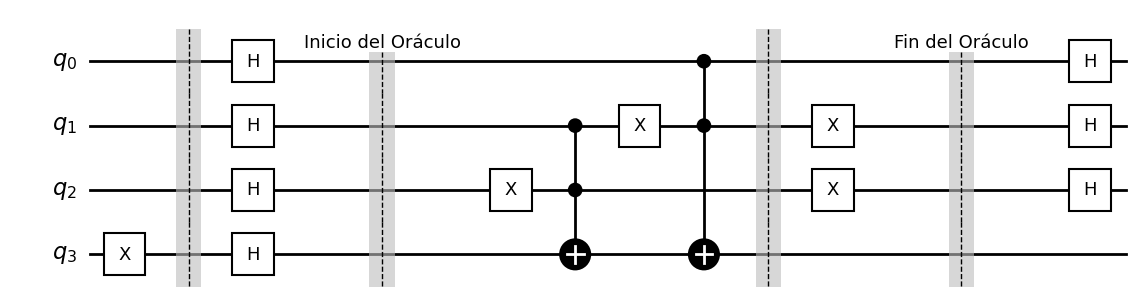

In [22]:
number_of_qubits = 4

result = deutsch_jozsa(number_of_qubits, oraculo)
result.draw(output='mpl', style='bw')

Se añaden las mediciones:

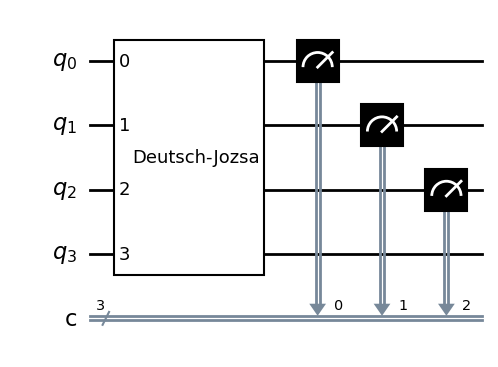

In [23]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits, number_of_qubits - 1)

measured_quantum_circuit.append(result, list(range(number_of_qubits)))

for i in range(number_of_qubits - 1): # -1 ya que no se quiere medir el auxiliar.
    measured_quantum_circuit.measure(i, i)
    
measured_quantum_circuit.draw(output='mpl', style='bw')

Se realiza la simulación:

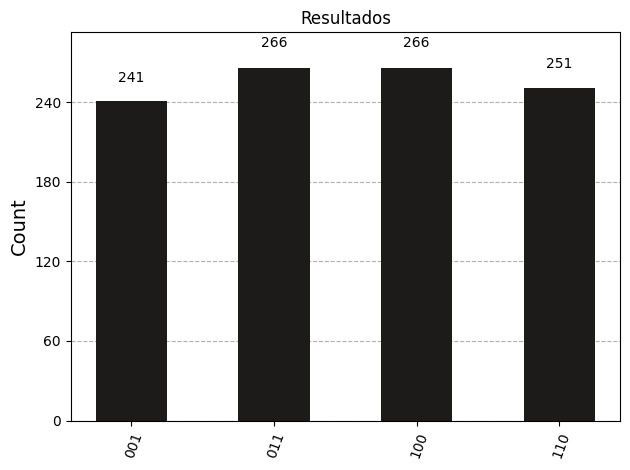

In [24]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

En el algoritmo de Deutsch-Jozsa:

- Si la función es constante, toda la probabilidad colapsa en un solo estado básico: el |000⟩.
- Por otro lado, si la función es balanceada, la probabilidad se reparte entre cualquier combinación de estados básicos **exceptuando** el |000⟩.

Como puede obversarse, los resultados presentados coinciden con la definición de función balanceada. Por consiguiente, queda demostrado que la función es balanceada.

## D) Deutsch-Jozsa - Función No Balanceada Ni Constante

Corresponde al ejemplo 4 del ejercicio 1 del TP de paralelismo.

![ejemploNro4.png](images/ejemploNro4.png)

Debido a que previamente ya se planteó el algoritmo de Deutsch-Jozsa, ahora solo hace falta plantear el oráculo para la función del ejercicio: f(x2, x1, x0) = 0

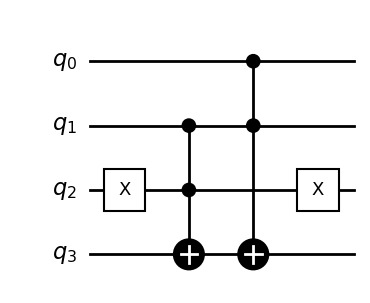

In [25]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que pueden acceder a través los índices.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.x(2)
    quantum_circuit.ccx(2, 1, accesible_qubits)
    quantum_circuit.ccx(1, 0, accesible_qubits)
    
    quantum_circuit.x(2)
    
    return quantum_circuit
    

qc = QuantumCircuit(4)
oraculo(qc, 4).draw(output='mpl', style='bw')

El cual puede generalizarse para _N_ qubits de la siguiente manera:

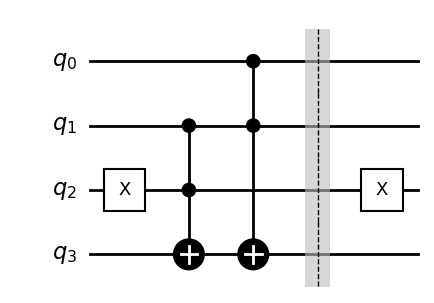

In [26]:
def oraculo(quantum_circuit, number_of_qubits):
    
    # Número de qubits que pueden acceder a través los índices.
    accesible_qubits = number_of_qubits - 1
    
    quantum_circuit.x(accesible_qubits - 1)
    
    for qubit in range(accesible_qubits - 1, 0, -1):
        quantum_circuit.ccx(qubit, qubit - 1, accesible_qubits)
    
    # Se coloca una barrera para evitar el reordenamiento
    # automático de Qiskit.
    quantum_circuit.barrier()
    
    quantum_circuit.x(accesible_qubits - 1)
    
    return quantum_circuit
    
number_of_qubits = 4

qc = QuantumCircuit(number_of_qubits)
oraculo(qc, number_of_qubits).draw(output='mpl', style='bw')

Aplicando el algoritmo de Deutsch-Jozsa, se obtiene el siguiente circuito:

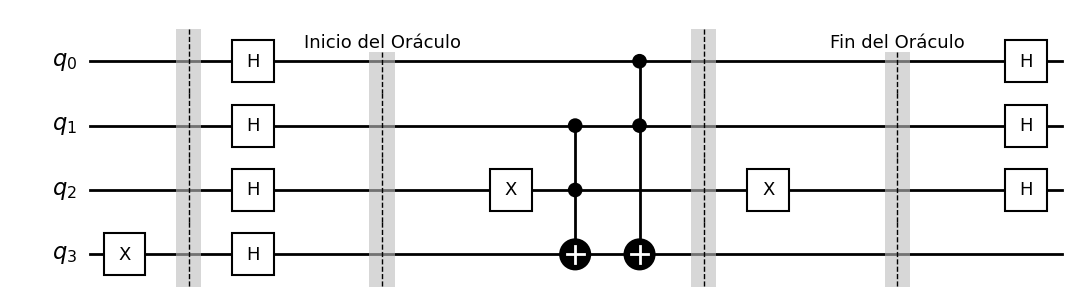

In [27]:
number_of_qubits = 4

result = deutsch_jozsa(number_of_qubits, oraculo)
result.draw(output='mpl', style='bw')

Se añaden las mediciones necesarias para realizar la simulación:

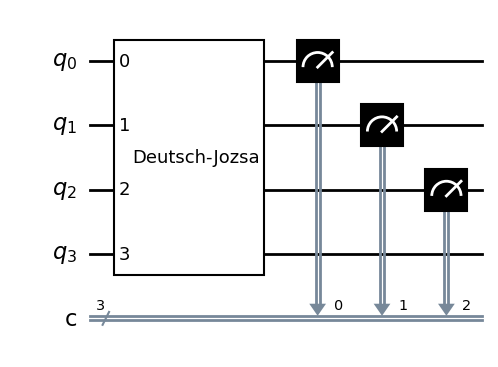

In [28]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits, number_of_qubits - 1)

measured_quantum_circuit.append(result, list(range(number_of_qubits)))

for i in range(number_of_qubits - 1): # -1 ya que no se quiere medir el auxiliar.
    measured_quantum_circuit.measure(i, i)

measured_quantum_circuit.draw(output='mpl', style='bw')

Se realiza la simulación y se presentan los resultados en forma de histograma:

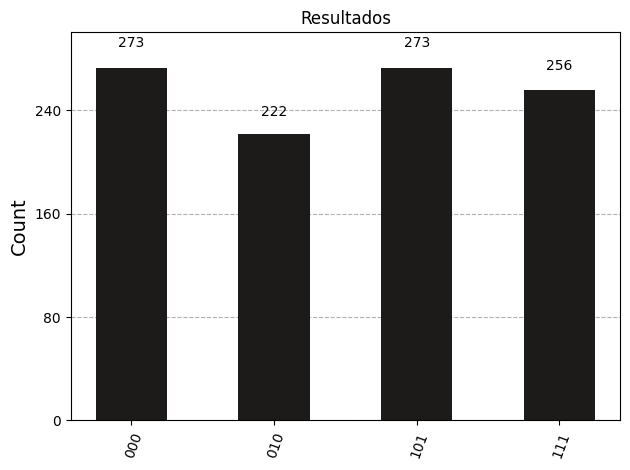

In [29]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

plot_histogram(counts, title="Resultados", color="#1D1A1A")

Como puede observarse, la función no cumple con los prerequisitos del algoritmo. Esta no es balanceada ni constante. Por consiguiente, los estados básicos que se miden son variados e incluyen al |000⟩.